trajectory forecasting with adaptive updating 

**Main Features**
- Brent Crude, WTI Crude, Dutch TTF Gas, Henry Hub Gas
- Equinor (EQNR.OL): Open, Close, High, Low, Volume, Market Cap
- OSEBX Index: Open, Close, High, Low, Volume
- VIX (volatility index)
- Dollar Index (DXY)

**Relevant Stocks**
- **Norway**: Aker BP (AKRBP), DNO (DNO), Vår Energi (VAR), Petroleum Geo-Services (PGS), BW Offshore (BWO), Frontline (FRO)
- **US/Global**: Exxon (XOM), Chevron (CVX), Shell (SHEL), BP (BP), TotalEnergies (TTE), ConocoPhillips (COP), Occidental (OXY)

**Stock Exchanges**
- S&P 500, NASDAQ, Dow Jones
- FTSE 100, DAX, CAC 40
- Nikkei 225, Hang Seng

**Commodity Prices**
- Gold (XAU), Silver (XAG)
- **Currencies**: USD/NOK, EUR/NOK, GBP/NOK, SEK/NOK, USD/EUR
- Coal (API2), Uranium (UX)
- Carbon Credits (EU ETS)

**Economic Indicators**
- **Interest Rates**: Norway (Norges Bank), US Fed Funds, ECB, BoE, BoJ, PBoC
- **Inflation**: Norway CPI, US CPI, EU HICP
- **Unemployment**: Norway, US, EU rates
- **Analyst Targets**: Equinor consensus price targets, EPS estimates


#### Fetch Dependencies

# Data fetching
import yfinance as yf

# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Optuna optimization
import optuna
from optuna.trial import TrialState

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Date and time handling
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

#### Collect Data

In [ ]:
# CELL 1: COLLECT DATA

def collect_data(start_date="2021-01-01", end_date=None):
    """Collect stock data and return as DataFrame"""
    end_date = end_date or datetime.now().strftime('%Y-%m-%d')
    
    # Updated tickers based on research
    tickers = {
        # Main stock
        'EQNR.OL': 'equinor',
       
        # Energy commodities
        'BZ=F': 'brent_crude',
        'CL=F': 'wti_crude',
        'TTF=F': 'ttf_gas',
        'NG=F': 'henry_hub',
       
        # Norwegian energy stocks
        'AKRBP.OL': 'aker_bp',
        'DNO.OL': 'dno',
        'VAR.OL': 'var_energi',
        'PGS.OL': 'pgs',
        'BWO.OL': 'bw_offshore',
        'FRO.OL': 'frontline',
       
        # Global energy stocks
        'XOM': 'exxon',
        'CVX': 'chevron',
        'SHEL': 'shell',
        'BP': 'bp',
        'TTE': 'totalenergies',
        'COP': 'conocophillips',
        'OXY': 'occidental',
       
        # Indices
        'OSEBX.OL': 'osebx',
        '^GSPC': 'sp500',
        '^IXIC': 'nasdaq',
        '^DJI': 'dow_jones',
        '^FTSE': 'ftse100',
        '^GDAXI': 'dax',
        '^FCHI': 'cac40',
        '^N225': 'nikkei',
        '^HSI': 'hang_seng',
       
        # Volatility and Dollar
        '^VIX': 'vix',
        'DX-Y.NYB': 'dollar_index',
       
        # Commodities
        'GC=F': 'gold',
        'SI=F': 'silver',
       
        # Currencies
        'NOK=X': 'usd_nok',
        'EURNOK=X': 'eur_nok',
        'GBPNOK=X': 'gbp_nok',
        'SEKNOK=X': 'sek_nok',
        'EURUSD=X': 'eur_usd'
    }
    
    all_data = {}
    
    # Download each ticker separately to avoid alignment issues
    for ticker, name in tickers.items():
        try:
            print(f"Downloading {name}...")
            # Download individually
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
            if len(data) > 0:
                # Only keep OHLC and Volume columns
                cols_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume']
                data = data[[c for c in cols_to_keep if c in data.columns]]
                # Handle column renaming - columns might be strings or tuples
                new_cols = []
                for col in data.columns:
                    if isinstance(col, tuple):
                        col_name = col[0] if len(col) > 0 else str(col)
                    else:
                        col_name = str(col)
                    new_cols.append(f"{name}_{col_name.lower()}")
                data.columns = new_cols
                all_data[name] = data
                print(f"  ✓ {name}: {len(data)} rows")
            else:
                print(f"  ✗ No data received for {ticker}")
                
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
    
    if not all_data:
        print("No data collected")
        return pd.DataFrame()
    
    # Combine using outer join to keep all dates
    df = pd.concat(all_data.values(), axis=1, join='outer')
    print(f"Combined data: {len(df)} rows, {len(df.columns)} columns")
    
    # Check initial NaN percentage
    nan_pct = df.isnull().sum().sum() / df.size * 100
    print(f"Initial NaN percentage: {nan_pct:.2f}%")
    
    # Keep only dates where Equinor traded (removes weekends/holidays)
    if 'equinor_close' in df.columns:
        before_filter = len(df)
        df = df[df['equinor_close'].notna()]
        print(f"Filtered to Equinor trading days: {before_filter} → {len(df)} rows")
    
    # Forward fill then backward fill to handle gaps
    df = df.ffill().bfill()
    
    # For any remaining NaNs at the beginning, drop those rows
    # This happens when some tickers start trading later than others
    first_valid_idx = df.first_valid_index()
    last_valid_idx = df.last_valid_index()
    if first_valid_idx and last_valid_idx:
        df = df.loc[first_valid_idx:last_valid_idx]
    
    # Final check for NaN percentage
    nan_count = df.isnull().sum().sum()
    if nan_count > 0:
        nan_pct_final = nan_count / df.size * 100
        print(f"Warning: {nan_count} NaN values remain ({nan_pct_final:.2f}%)")
        # Show which columns have NaNs
        nan_cols = df.columns[df.isnull().any()].tolist()
        if nan_cols:
            print(f"  Columns with NaNs: {nan_cols}")
    
    print(f"\nFinal data: {len(df)} rows, {len(df.columns)} columns")
    if len(df) > 0:
        print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
        nan_pct_final = df.isnull().sum().sum() / df.size * 100
        print(f"Final NaN percentage: {nan_pct_final:.2f}%")
    else:
        print("WARNING: No data remaining after processing")
    
    return df

In [ ]:
# Run collection
data = collect_data(start_date="2010-01-01")

#### Rate of Change

In [ ]:
# Add rate of change features
def add_rate_of_change(df):
    """Add rate of change features to existing dataframe"""
    
    # Key assets for rate of change analysis
    key_assets = ['equinor', 'brent_crude', 'wti_crude', 'usd_nok', 'vix']
    
    for asset in key_assets:
        close_col = f'{asset}_close'
        if close_col in df.columns:
            # First derivative (daily returns)
            df[f'{asset}_return'] = df[close_col].pct_change()
            
            # Second derivative (acceleration)
            df[f'{asset}_acceleration'] = df[f'{asset}_return'].diff()
            
            # Volatility momentum (20-day rolling vol change)
            rolling_vol = df[f'{asset}_return'].rolling(20).std()
            df[f'{asset}_vol_momentum'] = rolling_vol.pct_change()
    
    # Cross-asset correlation momentum (Equinor vs Brent)
    if 'equinor_return' in df.columns and 'brent_crude_return' in df.columns:
        rolling_corr = df['equinor_return'].rolling(20).corr(df['brent_crude_return'])
        df['eq_brent_corr_momentum'] = rolling_corr.diff()
    
    # Drop initial NaN rows created by calculations
    df = df.dropna()
    
    return df

# Apply to your data
data = add_rate_of_change(data)
print(f"After adding rate of change: {data.shape}")

#### Print Data

In [ ]:
# CELL 2: PRINT HEAD OF DATA
print(f"Shape: {data.shape}")
print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"Columns: {len(data.columns)}")
print(f"Remaining NaNs: {data.isnull().sum().sum()}")
print(f"NaN percentage: {data.isnull().sum().sum() / data.size * 100:.2f}%")
data.head()

#### Save Matrix to CSV

In [ ]:
# CELL 3: SAVE TO CSV
filepath = "data/equinor_data_8sept.csv"
data.to_csv(filepath)
print(f"Saved {len(data)} rows to {filepath}")

### Model

Using device: mps
NEXT-GENERATION TRANSFORMER PRICE FORECAST MODEL

1. Loading and preparing data...
   Found 36 assets: ['ttf_gas', 'var_energi', 'frontline', 'sp500', 'hang_seng']...
   Created 1960 features dynamically


[I 2025-09-09 12:34:59,686] A new study created in memory with name: no-name-0da4261f-6973-4745-aebc-5438813b246f


   Features: 1960
   Samples: 3884
   Current Price: $241.00
   Assets tracked: 36

2. Running Optuna hyperparameter optimization...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Train Loss: -1.6785, Val Loss: -1.1661
  Trajectory: 0.0021, Calibration: -1.1301
Epoch 10: Train Loss: -2.0468, Val Loss: -1.7990
  Trajectory: 0.0017, Calibration: -1.7378
[I 2025-09-09 12:37:16,164] Trial 0 finished with value: -1.5804447209835053 and parameters: {'d_model': 128, 'n_heads': 4, 'n_layers': 3, 'dropout': 0.2840740354514909, 'lr': 0.0009034537645485191, 'batch_size': 16}. Best is trial 0 with value: -1.5804447209835053.
Epoch 0: Train Loss: -1.5159, Val Loss: -1.7635
  Trajectory: 0.0019, Calibration: -1.7064
Epoch 10: Train Loss: -2.4162, Val Loss: -0.3394
  Trajectory: 0.0022, Calibration: -0.3036
Early stopping at epoch 15
[I 2025-09-09 12:38:44,425] Trial 1 finished with value: -0.39425256619086635 and parameters: {'d_model': 256, 'n_heads': 4, 'n_layers': 8, 'dropout': 0.22066642757958285, 'lr': 0.0001281317915072405, 'batch_size': 32}. Best is trial 0 with value: -1.5804447209835053.
Epoch 0: Train Loss: -0.6295, Val Loss: -1.2736
  Trajectory: 0.0017, C

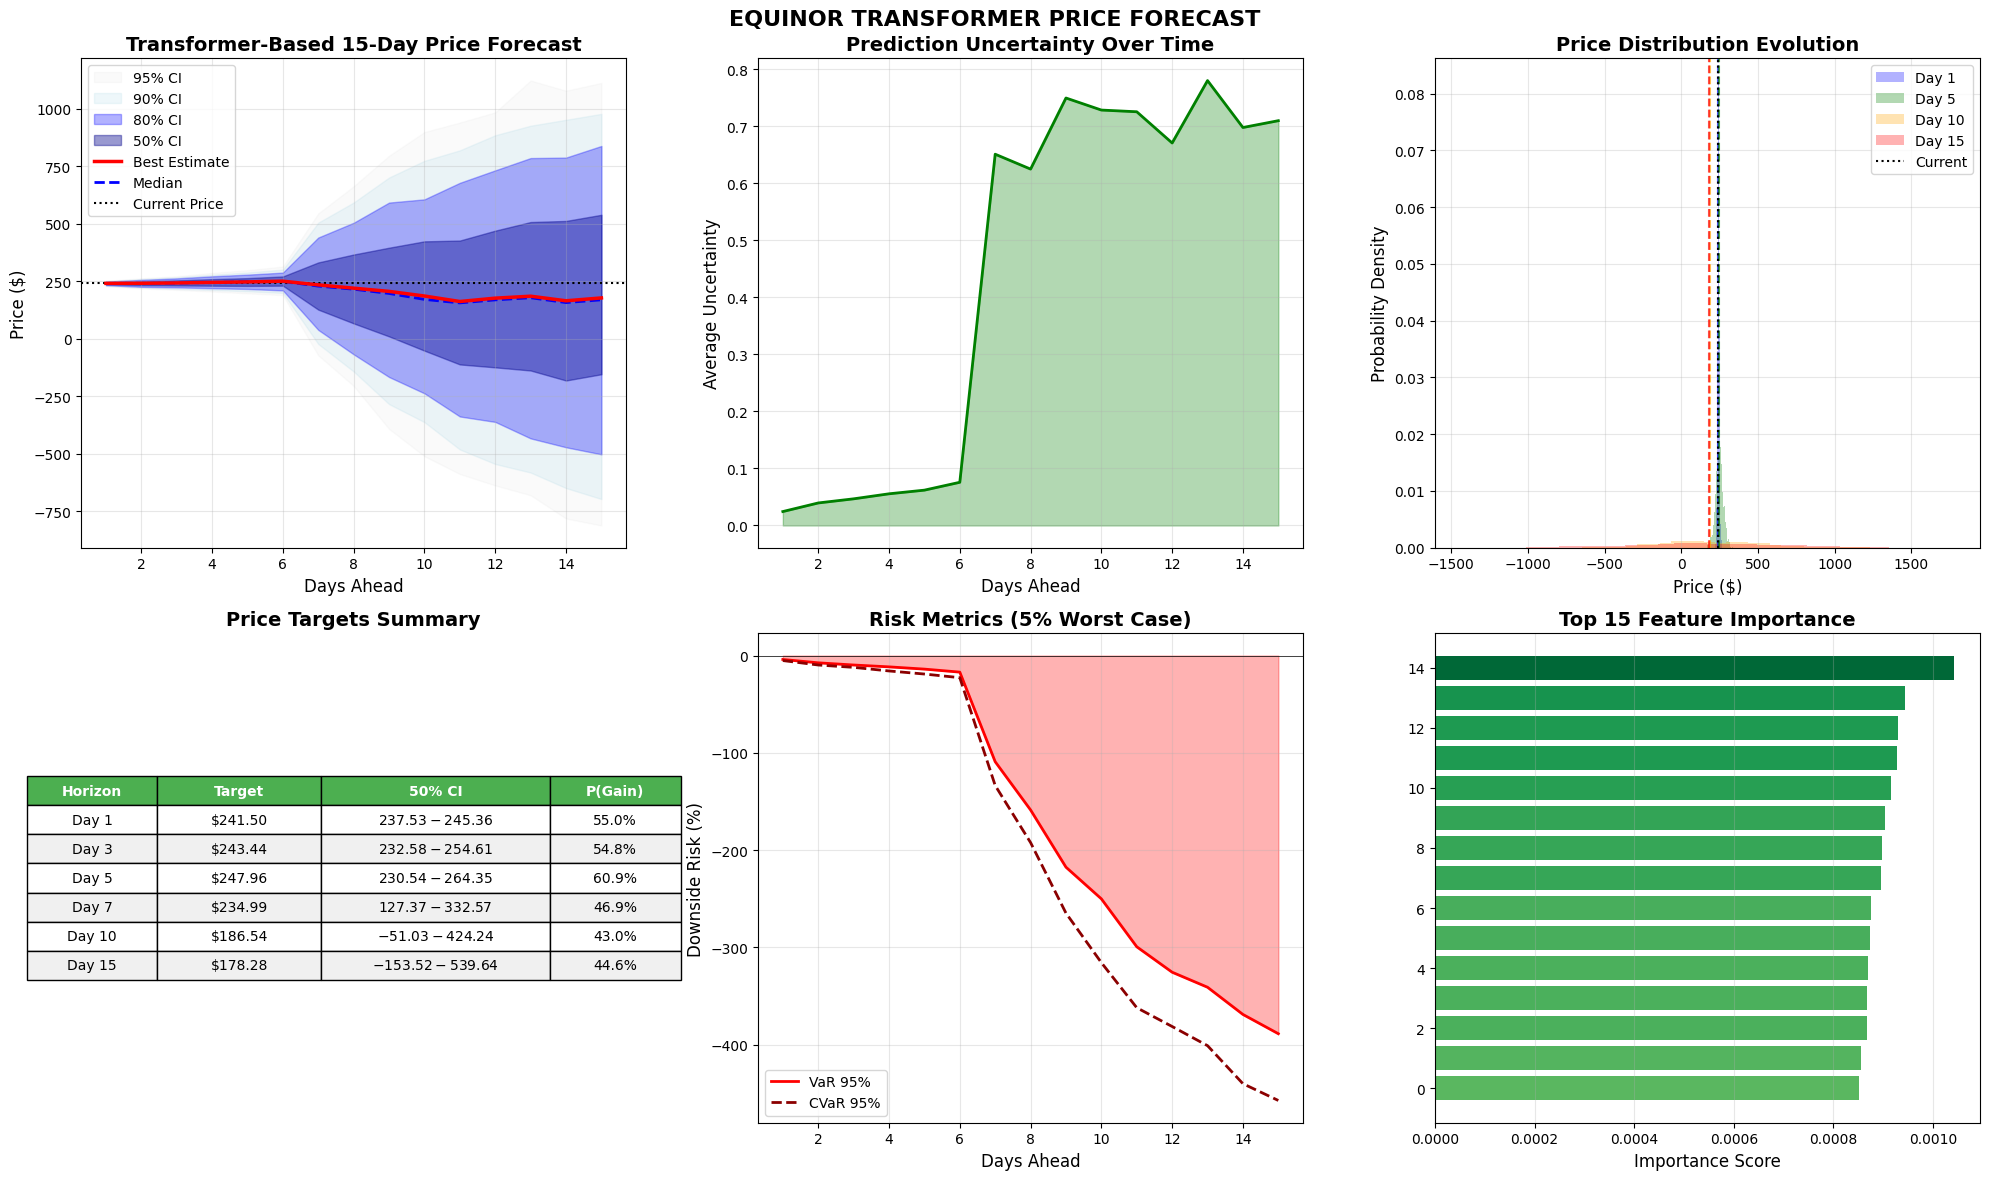


EQUINOR TRANSFORMER-BASED 15-DAY PRICE FORECAST
Current Price: $241.00

BEST ESTIMATE TRAJECTORY:
--------------------------------------------------------------------------------
Day  1: $241.50 [50% CI: $237.53-$245.36] Uncertainty: 0.024
Day  3: $243.44 [50% CI: $232.58-$254.61] Uncertainty: 0.047
Day  5: $247.96 [50% CI: $230.54-$264.35] Uncertainty: 0.062
Day  7: $234.99 [50% CI: $127.37-$332.57] Uncertainty: 0.651
Day 10: $186.54 [50% CI: $-51.03-$424.24] Uncertainty: 0.728
Day 15: $178.28 [50% CI: $-153.52-$539.64] Uncertainty: 0.709

PROBABILITY METRICS:
--------------------------------------------------------------------------------
Day  1: P(Gain)=55.0% | P(+5%)=2.0% | P(-5%)=2.3%
Day  5: P(Gain)=60.9% | P(+5%)=40.8% | P(-5%)=22.5%
Day 10: P(Gain)=43.0% | P(+5%)=41.8% | P(-5%)=56.1%
Day 15: P(Gain)=44.6% | P(+5%)=43.8% | P(-5%)=54.4%

Transformer model training complete! Advanced forecast generated.


In [3]:
"""
Next-Generation Equinor Price Forecast Model
Using Transformer Architecture with Generative Trajectory Decoding
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import optuna
from optuna.trial import TrialState
import math
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================================================
# DATA PREPARATION (Keep existing feature engineering)
# ============================================================================

def prepare_distribution_data(filepath='data/equinor_data_8sept.csv'):
    """Dynamically prepare data with domain-specific features"""
    data = pd.read_csv(filepath, index_col=0, parse_dates=True)
    
    # Calculate next-day targets for multiple horizons
    horizons = [1, 3, 5, 7, 10, 15]
    for h in horizons:
        data[f'return_{h}d'] = data['equinor_close'].pct_change(h).shift(-h)
        data[f'volatility_{h}d'] = data['equinor_close'].pct_change(1).rolling(20).std().shift(-h)
    
    # Store original columns
    original_columns = set(data.columns)
    
    # Detect all assets dynamically
    price_columns = [col for col in data.columns if 'close' in col.lower()]
    assets = list(set([col.replace('_close', '') for col in price_columns]))
    
    print(f"   Found {len(assets)} assets: {assets[:5]}...")
    
    # Generate features for each asset
    for asset in assets:
        base_col = f'{asset}_close' if f'{asset}_close' in data.columns else None
        
        if base_col is not None and base_col in data.columns:  # Fix: Explicit None check
            # Returns at multiple horizons
            for period in [1, 2, 3, 5, 7, 10, 15, 20, 30, 60]:
                data[f'{asset}_ret_{period}d'] = data[base_col].pct_change(period)
            
            # Log returns
            data[f'{asset}_logret_1d'] = np.log(data[base_col] / data[base_col].shift(1))
            
            # Volatility features
            for period in [5, 10, 20, 30, 60]:
                data[f'{asset}_vol_{period}d'] = data[f'{asset}_ret_1d'].rolling(period).std()
                data[f'{asset}_vol_skew_{period}d'] = data[f'{asset}_ret_1d'].rolling(period).skew()
                data[f'{asset}_vol_kurt_{period}d'] = data[f'{asset}_ret_1d'].rolling(period).kurt()
            
            # Moving averages
            for period in [5, 10, 20, 50, 100, 200]:
                if len(data) >= period:
                    data[f'{asset}_ma{period}'] = data[base_col].rolling(period).mean()
                    data[f'{asset}_rel_ma{period}'] = data[base_col] / data[f'{asset}_ma{period}'] - 1
            
            # Technical indicators
            for period in [5, 10, 20]:
                data[f'{asset}_min_{period}d'] = data[base_col].rolling(period).min()
                data[f'{asset}_max_{period}d'] = data[base_col].rolling(period).max()
                data[f'{asset}_range_{period}d'] = (data[base_col] - data[f'{asset}_min_{period}d']) / \
                                                   (data[f'{asset}_max_{period}d'] - data[f'{asset}_min_{period}d'] + 1e-10)
            
            # RSI
            delta = data[base_col].diff()
            gain = (delta.where(delta > 0, 0)).rolling(14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
            rs = gain / (loss + 1e-10)
            data[f'{asset}_rsi'] = 100 - (100 / (1 + rs))
            
            # MACD
            exp1 = data[base_col].ewm(span=12, adjust=False).mean()
            exp2 = data[base_col].ewm(span=26, adjust=False).mean()
            data[f'{asset}_macd'] = exp1 - exp2
            data[f'{asset}_macd_signal'] = data[f'{asset}_macd'].ewm(span=9, adjust=False).mean()
            
            # Bollinger Bands
            ma20 = data[base_col].rolling(20).mean()
            std20 = data[base_col].rolling(20).std()
            data[f'{asset}_bb_upper'] = ma20 + (std20 * 2)
            data[f'{asset}_bb_lower'] = ma20 - (std20 * 2)
            data[f'{asset}_bb_pos'] = (data[base_col] - data[f'{asset}_bb_lower']) / \
                                      (data[f'{asset}_bb_upper'] - data[f'{asset}_bb_lower'] + 1e-10)
    
    # DOMAIN-SPECIFIC FEATURES FOR EQUINOR
    if all(col in data.columns for col in ['brent_crude_ret_1d', 'usd_nok_ret_1d']):
        data['oil_equity_signal'] = (
            data.get('brent_crude_ret_1d', 0) * 0.5 +
            data.get('osebx_ret_1d', 0) * 0.3 +
            data.get('usd_nok_ret_1d', 0) * -0.2
        )
        
        data['oil_equity_divergence'] = (
            data.get('brent_crude_ret_5d', 0) - data.get('equinor_ret_5d', 0)
        )
    
    # Energy sector momentum
    energy_assets = ['aker_bp', 'var_energi', 'dno', 'equinor']
    energy_returns = []
    for asset in energy_assets:
        ret_col = f'{asset}_ret_1d'
        if ret_col in data.columns:
            energy_returns.append(data[ret_col])
    
    if energy_returns:
        data['energy_momentum'] = pd.concat(energy_returns, axis=1).mean(axis=1)
        data['energy_momentum_5d'] = pd.concat([data[f'{asset}_ret_5d'] 
                                                for asset in energy_assets 
                                                if f'{asset}_ret_5d' in data.columns], axis=1).mean(axis=1)
    
    # Macro signals
    if 'vix_close' in data.columns:
        data['risk_on_signal'] = -data['vix_close'].pct_change(5)
    
    # Cross-asset correlations
    return_cols = [col for col in data.columns if '_ret_1d' in col]
    for i, col1 in enumerate(return_cols[:10]):
        for col2 in return_cols[i+1:i+3]:
            asset1 = col1.replace('_ret_1d', '')
            asset2 = col2.replace('_ret_1d', '')
            
            for period in [5, 20]:
                data[f'{asset1}_{asset2}_corr{period}'] = data[col1].rolling(period).corr(data[col2])
    
    # Calendar features
    data['day_of_week'] = pd.to_datetime(data.index).dayofweek
    data['month'] = pd.to_datetime(data.index).month
    data['quarter'] = pd.to_datetime(data.index).quarter
    
    # Cyclical encoding
    data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # Get all new features
    new_columns = set(data.columns) - original_columns
    feature_columns = [col for col in new_columns 
                      if not any(f'{metric}_{h}d' in col 
                                for metric in ['return', 'volatility'] 
                                for h in horizons)]
    
    print(f"   Created {len(feature_columns)} features dynamically")
    
    # Select features and handle missing values
    X = data[feature_columns].ffill().bfill().fillna(0)
    X = X.replace([np.inf, -np.inf], [1e6, -1e6])
    
    # Multi-horizon targets
    y_returns = {}
    y_volatilities = {}
    for h in horizons:
        y_returns[h] = data[f'return_{h}d'].clip(lower=-0.15, upper=0.15)
        y_volatilities[h] = data[f'volatility_{h}d'].clip(lower=0.001, upper=0.05)
    
    # Remove NaN targets - combine all boolean masks properly
    valid_masks = []
    for h in horizons:
        mask = ~(y_returns[h].isna() | y_volatilities[h].isna())
        valid_masks.append(mask)
    
    # Combine all masks using pandas boolean operations
    valid_idx = valid_masks[0]
    for mask in valid_masks[1:]:
        valid_idx = valid_idx & mask
    
    X = X[valid_idx]
    for h in horizons:
        y_returns[h] = y_returns[h][valid_idx]
        y_volatilities[h] = y_volatilities[h][valid_idx]
    
    # Get current price and asset list for graph modeling
    current_price = data['equinor_close'].iloc[-1]
    
    return X, y_returns, y_volatilities, current_price, assets

# ============================================================================
# POSITIONAL ENCODING FOR TIME SERIES
# ============================================================================

class TemporalEncoding(nn.Module):
    """Positional encoding for time series data"""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # x shape: [batch, seq_len, d_model]
        return x + self.pe[:, :x.size(1)]

# ============================================================================
# GRAPH ATTENTION LAYER
# ============================================================================

class GraphAttentionLayer(nn.Module):
    """Learn dynamic relationships between assets"""
    def __init__(self, d_model, n_heads=4):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        batch_size, seq_len, d_model = x.size()
        
        # Multi-head attention for graph relationships
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Compute attention scores (relationships between features/assets)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        
        output = self.W_o(context)
        return output + x  # Residual connection

# ============================================================================
# HIERARCHICAL ENCODER
# ============================================================================

class HierarchicalEncoder(nn.Module):
    """Process features at multiple time scales"""
    def __init__(self, d_model, n_heads=8):
        super().__init__()
        
        # Different time scale encoders
        self.short_term = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, 
            dim_feedforward=d_model*4, dropout=0.1
        )
        self.medium_term = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=d_model*4, dropout=0.1
        )
        self.long_term = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=d_model*4, dropout=0.1
        )
        
        # Fusion mechanism
        self.fusion = nn.MultiheadAttention(d_model, n_heads, dropout=0.1, batch_first=True)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        # Process at different scales
        short = self.short_term(x)
        medium = self.medium_term(x)
        long = self.long_term(x)
        
        # Stack for fusion
        multi_scale = torch.stack([short, medium, long], dim=1)
        batch_size, n_scales, seq_len, d_model = multi_scale.size()
        
        # Reshape for attention
        multi_scale = multi_scale.view(batch_size, n_scales * seq_len, d_model)
        
        # Self-attention fusion
        fused, _ = self.fusion(multi_scale, multi_scale, multi_scale)
        
        # Take mean across scales
        fused = fused.view(batch_size, n_scales, seq_len, d_model).mean(dim=1)
        
        return self.norm(fused + x)

# ============================================================================
# TRAJECTORY DECODER
# ============================================================================

class TrajectoryDecoder(nn.Module):
    """Generates entire price trajectory in one forward pass"""
    def __init__(self, d_model, horizon=15):
        super().__init__()
        self.horizon = horizon
        
        # Trajectory generation network
        self.trajectory_net = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Linear(d_model, horizon)
        )
        
        # Uncertainty estimation network
        self.uncertainty_net = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model, horizon),
            nn.Softplus()
        )
        
        # Rank prediction for each timestep
        self.rank_net = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model, horizon * 5)  # 5 ranks for each timestep
        )
        
    def forward(self, encoded_features):
        # Generate full trajectory at once
        returns = self.trajectory_net(encoded_features)
        uncertainties = self.uncertainty_net(encoded_features)
        
        # Rank predictions
        rank_logits = self.rank_net(encoded_features)
        batch_size = encoded_features.size(0)
        rank_logits = rank_logits.view(batch_size, self.horizon, 5)
        
        return returns, uncertainties, rank_logits

# ============================================================================
# NEXT-GEN EQUINOR MODEL
# ============================================================================

class NextGenEquinorModel(nn.Module):
    def __init__(self, input_features, d_model=256, n_heads=8, n_layers=6, 
                 horizon=15, dropout=0.1):
        super().__init__()
        
        # Feature processing
        self.feature_encoder = nn.Sequential(
            nn.Linear(input_features, d_model * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model)
        )
        
        # Add temporal encoding
        self.temporal_encoding = TemporalEncoding(d_model)
        
        # Graph attention for asset relationships
        self.graph_layer = GraphAttentionLayer(d_model, n_heads=n_heads//2)
        
        # Hierarchical encoding
        self.hierarchical_encoder = HierarchicalEncoder(d_model, n_heads)
        
        # Main transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        
        # Trajectory generation
        self.trajectory_generator = TrajectoryDecoder(d_model, horizon)
        
        # Feature importance extraction
        self.feature_importance = nn.Sequential(
            nn.Linear(d_model, input_features),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Encode features
        features = self.feature_encoder(x)
        features = features.unsqueeze(1)  # Add sequence dimension
        
        # Add temporal encoding
        features = self.temporal_encoding(features)
        
        # Model asset relationships
        graph_features = self.graph_layer(features)
        
        # Hierarchical multi-scale encoding
        multi_scale = self.hierarchical_encoder(graph_features)
        
        # Core transformer processing
        encoded = self.transformer(multi_scale)
        
        # Pool encoded features
        encoded_pooled = encoded.mean(dim=1)  # Global average pooling
        
        # Generate full trajectory
        trajectory, uncertainty, rank_logits = self.trajectory_generator(encoded_pooled)
        
        # Extract feature importance
        importance = self.feature_importance(encoded_pooled)
        
        return trajectory, uncertainty, rank_logits, importance

# ============================================================================
# ENHANCED TRAJECTORY LOSS
# ============================================================================

class TrajectoryDistributionLoss(nn.Module):
    def __init__(self, horizon=15, alpha=1.0, beta=1.0, gamma=1.0, 
                 sharpness_weight=2.0, smoothness_weight=0.5):
        super().__init__()
        self.horizon = horizon
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.sharpness_weight = sharpness_weight
        self.smoothness_weight = smoothness_weight
        self.mse = nn.MSELoss()
        self.ce = nn.CrossEntropyLoss()
        
    def path_wise_loss(self, pred_trajectory, true_trajectory):
        """Loss for entire trajectory prediction"""
        # MSE for each timestep
        timestep_losses = (pred_trajectory - true_trajectory) ** 2
        
        # Weight later timesteps less
        time_weights = torch.exp(-torch.arange(self.horizon, device=pred_trajectory.device) * 0.05)
        weighted_loss = (timestep_losses * time_weights).mean()
        
        return weighted_loss
    
    def uncertainty_calibration_loss(self, pred_uncertainty, actual_errors):
        """Ensure uncertainties match actual prediction errors"""
        # Uncertainties should correlate with actual errors
        eps = 1e-6
        
        # NLL assuming Gaussian distribution
        nll = 0.5 * (torch.log(2 * np.pi * (pred_uncertainty + eps) ** 2) + 
                    (actual_errors ** 2) / ((pred_uncertainty + eps) ** 2))
        
        return nll.mean()
    
    def forward(self, pred_trajectory, pred_uncertainty, rank_logits, 
                true_returns, true_volatilities):
        
        # Path-wise trajectory loss
        trajectory_loss = self.path_wise_loss(pred_trajectory, true_returns)
        
        # Uncertainty calibration
        actual_errors = (pred_trajectory - true_returns).abs()
        calibration_loss = self.uncertainty_calibration_loss(pred_uncertainty, actual_errors)
        
        # Sharpness reward (prefer confident predictions when correct)
        correct_mask = (pred_trajectory - true_returns).abs() < 0.01  # Within 1% error
        if correct_mask.any():
            sharpness_bonus = -torch.mean(pred_uncertainty[correct_mask]) * self.sharpness_weight
        else:
            sharpness_bonus = 0
        
        # Temporal smoothness
        trajectory_diff = pred_trajectory[:, 1:] - pred_trajectory[:, :-1]
        smoothness_loss = torch.mean(trajectory_diff ** 2) * self.smoothness_weight
        
        # Volatility prediction
        vol_loss = self.mse(pred_uncertainty, true_volatilities)
        
        # Total loss
        total_loss = (self.alpha * trajectory_loss + 
                     self.beta * calibration_loss + 
                     self.gamma * vol_loss +
                     sharpness_bonus + 
                     smoothness_loss)
        
        metrics = {
            'trajectory_loss': trajectory_loss.item(),
            'calibration_loss': calibration_loss.item(),
            'vol_loss': vol_loss.item(),
            'sharpness': sharpness_bonus.item() if torch.is_tensor(sharpness_bonus) else 0.0,
            'smoothness': smoothness_loss.item()
        }
        
        return total_loss, metrics

# ============================================================================
# DATASET FOR TRAJECTORY LEARNING
# ============================================================================

class TrajectoryDataset(Dataset):
    def __init__(self, features, returns_dict, volatilities_dict, horizon=15):
        self.features = torch.FloatTensor(features.values if hasattr(features, 'values') else features)
        self.horizon = horizon
        
        # Stack returns and volatilities for all horizons
        horizons = [1, 3, 5, 7, 10, 15]
        returns_list = []
        vols_list = []
        
        for h in horizons[:6]:  # Use first 6 horizons
            if h <= horizon:
                returns_list.append(returns_dict[h].values if hasattr(returns_dict[h], 'values') else returns_dict[h])
                vols_list.append(volatilities_dict[h].values if hasattr(volatilities_dict[h], 'values') else volatilities_dict[h])
        
        self.returns = torch.FloatTensor(np.column_stack(returns_list))
        self.volatilities = torch.FloatTensor(np.column_stack(vols_list))
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.returns[idx], self.volatilities[idx]

# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_transformer_model(model, X_train, y_returns_train, y_vols_train,
                           X_val, y_returns_val, y_vols_val,
                           epochs=100, batch_size=32, lr=0.001):
    """Train the transformer model"""
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    max_patience = 15
    
    # Create datasets
    train_dataset = TrajectoryDataset(X_train, y_returns_train, y_vols_train)
    val_dataset = TrajectoryDataset(X_val, y_returns_val, y_vols_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Optimizer with different learning rates
    optimizer = torch.optim.AdamW([
        {'params': model.feature_encoder.parameters(), 'lr': lr * 2},
        {'params': model.transformer.parameters(), 'lr': lr},
        {'params': model.trajectory_generator.parameters(), 'lr': lr * 1.5}
    ], weight_decay=1e-5)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2
    )
    
    criterion = TrajectoryDistributionLoss(horizon=6)  # Using 6 time points
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_metrics = {'trajectory_loss': 0, 'calibration_loss': 0, 
                        'vol_loss': 0, 'sharpness': 0, 'smoothness': 0}
        epoch_train_loss = 0
        
        for features, returns, vols in train_loader:
            features = features.to(device)
            returns = returns.to(device)
            vols = vols.to(device)
            
            optimizer.zero_grad()
            
            trajectory, uncertainty, rank_logits, _ = model(features)
            
            # Adjust trajectory shape to match targets
            trajectory = trajectory[:, :6]  # Use first 6 predictions
            uncertainty = uncertainty[:, :6]
            
            loss, metrics = criterion(trajectory, uncertainty, rank_logits, returns, vols)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
            for key in train_metrics:
                train_metrics[key] += metrics[key]
        
        # Validation
        model.eval()
        val_metrics = {'trajectory_loss': 0, 'calibration_loss': 0,
                      'vol_loss': 0, 'sharpness': 0, 'smoothness': 0}
        epoch_val_loss = 0
        
        with torch.no_grad():
            for features, returns, vols in val_loader:
                features = features.to(device)
                returns = returns.to(device)
                vols = vols.to(device)
                
                trajectory, uncertainty, rank_logits, _ = model(features)
                trajectory = trajectory[:, :6]
                uncertainty = uncertainty[:, :6]
                
                loss, metrics = criterion(trajectory, uncertainty, rank_logits, returns, vols)
                
                epoch_val_loss += loss.item()
                for key in val_metrics:
                    val_metrics[key] += metrics[key]
        
        train_losses.append(epoch_train_loss / len(train_loader))
        val_losses.append(epoch_val_loss / len(val_loader))
        
        scheduler.step()
        
        # Early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping at epoch {epoch}")
                model.load_state_dict(best_model_state)
                break
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
            print(f"  Trajectory: {val_metrics['trajectory_loss']/len(val_loader):.4f}, "
                  f"Calibration: {val_metrics['calibration_loss']/len(val_loader):.4f}")
    
    return model, train_losses, val_losses

# ============================================================================
# TRAJECTORY GENERATION
# ============================================================================

@torch.no_grad()
def generate_price_trajectories_transformer(model, initial_features, current_price, 
                                           n_trajectories=1000, horizon=15):
    """Generate price trajectories using the transformer model"""
    model.eval()
    device = next(model.parameters()).device
    batch_size = 100
    all_trajectories = []
    all_uncertainties = []
    all_ranks = []
    
    # Process in batches
    for batch_start in range(0, n_trajectories, batch_size):
        batch_end = min(batch_start + batch_size, n_trajectories)
        current_batch_size = batch_end - batch_start
        
        # Repeat features for batch
        features = initial_features.repeat(current_batch_size, 1).to(device)
        
        # Add noise for diversity
        features = features + torch.randn_like(features) * 0.01
        
        # Generate trajectories
        trajectory, uncertainty, rank_logits, _ = model(features)
        
        # Sample from distributions
        sampled_trajectories = []
        for i in range(current_batch_size):
            traj = []
            for t in range(horizon):
                if t < trajectory.size(1):
                    mean = trajectory[i, t]
                    std = uncertainty[i, t]
                    sampled_return = torch.normal(mean, std)
                else:
                    # Extrapolate for longer horizons
                    sampled_return = trajectory[i, -1] * (1 + 0.01 * (t - trajectory.size(1)))
                traj.append(sampled_return.cpu().item())
            sampled_trajectories.append(traj)
        
        all_trajectories.append(np.array(sampled_trajectories))
        all_uncertainties.append(uncertainty.cpu().numpy())
        
        # Get rank predictions
        rank_probs = F.softmax(rank_logits, dim=-1)
        predicted_ranks = torch.argmax(rank_probs, dim=-1)
        all_ranks.append(predicted_ranks.cpu().numpy())
    
    # Concatenate all batches
    trajectories = np.vstack(all_trajectories)
    uncertainties = np.vstack(all_uncertainties)
    ranks = np.vstack(all_ranks)
    
    # Convert returns to prices
    cumulative_returns = np.cumsum(trajectories, axis=1)
    price_trajectories = current_price * (1 + cumulative_returns)
    
    # Calculate best estimate (mean trajectory)
    best_estimate_returns = trajectories.mean(axis=0)
    best_estimate_cumulative = np.cumsum(best_estimate_returns)
    best_estimate_prices = current_price * (1 + best_estimate_cumulative)
    
    return price_trajectories, ranks, best_estimate_prices, uncertainties

# ============================================================================
# FORECAST GENERATION
# ============================================================================

def generate_price_forecast_transformer(price_trajectories, best_estimate_prices, 
                                       uncertainties, current_price, start_date=None):
    """Generate comprehensive price forecast"""
    
    if start_date is None:
        start_date = datetime.now()
    
    confidence_levels = {
        '50%': (25, 75),
        '80%': (10, 90),
        '90%': (5, 95),
        '95%': (2.5, 97.5)
    }
    
    forecast_data = []
    horizon = price_trajectories.shape[1]
    
    for day in range(1, horizon + 1):
        date = start_date + timedelta(days=day)
        day_prices = price_trajectories[:, day-1]
        
        row = {
            'Date': date,
            'Day': day,
            'Best_Estimate': best_estimate_prices[day-1],
            'Median': np.median(day_prices),
            'Mean': np.mean(day_prices),
            'Avg_Uncertainty': uncertainties[:, min(day-1, uncertainties.shape[1]-1)].mean() if day <= uncertainties.shape[1] else uncertainties[:, -1].mean()
        }
        
        # Add confidence intervals
        for conf_name, (lower_pct, upper_pct) in confidence_levels.items():
            row[f'CI_{conf_name}_Lower'] = np.percentile(day_prices, lower_pct)
            row[f'CI_{conf_name}_Upper'] = np.percentile(day_prices, upper_pct)
        
        # Probability metrics
        row['Prob_Above_Current'] = (day_prices > current_price).mean()
        row['Prob_Gain_5pct'] = (day_prices > current_price * 1.05).mean()
        row['Prob_Loss_5pct'] = (day_prices < current_price * 0.95).mean()
        
        forecast_data.append(row)
    
    forecast_df = pd.DataFrame(forecast_data)
    return forecast_df

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_transformer_forecast(forecast_df, price_trajectories, ranks, 
                            current_price, feature_importance=None):
    """Create comprehensive visualizations"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # Main forecast plot
    ax1 = plt.subplot(2, 3, 1)
    days = forecast_df['Day'].values
    
    # Plot confidence intervals
    colors = {'50%': 'darkblue', '80%': 'blue', '90%': 'lightblue', '95%': 'lightgray'}
    alphas = {'50%': 0.4, '80%': 0.3, '90%': 0.2, '95%': 0.1}
    
    for conf_level in ['95%', '90%', '80%', '50%']:
        ax1.fill_between(days, 
                         forecast_df[f'CI_{conf_level}_Lower'], 
                         forecast_df[f'CI_{conf_level}_Upper'],
                         alpha=alphas[conf_level], 
                         color=colors[conf_level], 
                         label=f'{conf_level} CI')
    
    ax1.plot(days, forecast_df['Best_Estimate'], 'r-', linewidth=2.5, 
             label='Best Estimate', zorder=5)
    ax1.plot(days, forecast_df['Median'], 'b--', linewidth=2, 
             label='Median', zorder=4)
    ax1.axhline(y=current_price, color='black', linestyle=':', 
                linewidth=1.5, label='Current Price')
    
    ax1.set_xlabel('Days Ahead', fontsize=12)
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.set_title('Transformer-Based 15-Day Price Forecast', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Uncertainty evolution
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(days, forecast_df['Avg_Uncertainty'], 'g-', linewidth=2)
    ax2.fill_between(days, 0, forecast_df['Avg_Uncertainty'], alpha=0.3, color='green')
    ax2.set_xlabel('Days Ahead', fontsize=12)
    ax2.set_ylabel('Average Uncertainty', fontsize=12)
    ax2.set_title('Prediction Uncertainty Over Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Price distribution
    ax3 = plt.subplot(2, 3, 3)
    horizons = [1, 5, 10, 15]
    colors_dist = ['blue', 'green', 'orange', 'red']
    
    for horizon, color in zip(horizons, colors_dist):
        if horizon <= price_trajectories.shape[1]:
            prices = price_trajectories[:, horizon-1]
            ax3.hist(prices, bins=30, alpha=0.3, color=color, 
                    label=f'Day {horizon}', density=True)
            best_est = forecast_df[forecast_df['Day'] == horizon]['Best_Estimate'].iloc[0]
            ax3.axvline(x=best_est, color=color, linestyle='--', alpha=0.7)
    
    ax3.axvline(x=current_price, color='black', linestyle=':', 
                linewidth=1.5, label='Current')
    ax3.set_xlabel('Price ($)', fontsize=12)
    ax3.set_ylabel('Probability Density', fontsize=12)
    ax3.set_title('Price Distribution Evolution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Price targets table
    ax4 = plt.subplot(2, 3, 4)
    ax4.axis('tight')
    ax4.axis('off')
    
    key_days = [1, 3, 5, 7, 10, 15]
    table_data = []
    
    for day in key_days:
        if day <= len(forecast_df):
            row_data = forecast_df[forecast_df['Day'] == day].iloc[0]
            table_data.append([
                f"Day {day}",
                f"${row_data['Best_Estimate']:.2f}",
                f"${row_data['CI_50%_Lower']:.2f}-${row_data['CI_50%_Upper']:.2f}",
                f"{row_data['Prob_Above_Current']*100:.1f}%"
            ])
    
    table = ax4.table(cellText=table_data,
                     colLabels=['Horizon', 'Target', '50% CI', 'P(Gain)'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.2, 0.25, 0.35, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    for i in range(len(table_data) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
    
    ax4.set_title('Price Targets Summary', fontsize=14, fontweight='bold')
    
    # Risk metrics
    ax5 = plt.subplot(2, 3, 5)
    var_95 = []
    cvar_95 = []
    for day in range(1, len(days) + 1):
        day_returns = (price_trajectories[:, day-1] / current_price - 1) * 100
        var_95.append(np.percentile(day_returns, 5))
        cvar_95.append(day_returns[day_returns <= np.percentile(day_returns, 5)].mean())
    
    ax5.plot(days, var_95, 'r-', linewidth=2, label='VaR 95%')
    ax5.plot(days, cvar_95, 'darkred', linewidth=2, linestyle='--', label='CVaR 95%')
    ax5.fill_between(days, 0, var_95, alpha=0.3, color='red')
    ax5.set_xlabel('Days Ahead', fontsize=12)
    ax5.set_ylabel('Downside Risk (%)', fontsize=12)
    ax5.set_title('Risk Metrics (5% Worst Case)', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Feature importance
    if feature_importance is not None:
        ax6 = plt.subplot(2, 3, 6)
        top_n = 15
        top_features_idx = np.argsort(feature_importance)[-top_n:]
        top_importance = feature_importance[top_features_idx]
        
        colors_feat = plt.cm.RdYlGn(top_importance / top_importance.max())
        ax6.barh(range(top_n), top_importance, color=colors_feat)
        ax6.set_xlabel('Importance Score', fontsize=12)
        ax6.set_title(f'Top {top_n} Feature Importance', fontsize=14, fontweight='bold')
        ax6.grid(True, alpha=0.3, axis='x')
    
    plt.suptitle('EQUINOR TRANSFORMER PRICE FORECAST', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

# ============================================================================
# OPTUNA OPTIMIZATION FOR TRANSFORMER
# ============================================================================

def optimize_transformer_hyperparameters(X_train, y_returns_train, y_vols_train,
                                        X_val, y_returns_val, y_vols_val,
                                        n_trials=30):
    """Optimize hyperparameters using Optuna"""
    
    def objective(trial):
        # Hyperparameters
        d_model = trial.suggest_categorical('d_model', [128, 256, 512])
        n_heads = trial.suggest_categorical('n_heads', [4, 8, 16])
        n_layers = trial.suggest_int('n_layers', 2, 8)
        dropout = trial.suggest_float('dropout', 0.1, 0.5)
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        
        # Create model
        model = NextGenEquinorModel(
            input_features=X_train.shape[1],
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            dropout=dropout
        )
        
        # Train for fewer epochs during optimization
        model, train_losses, val_losses = train_transformer_model(
            model, X_train, y_returns_train, y_vols_train,
            X_val, y_returns_val, y_vols_val,
            epochs=20, batch_size=batch_size, lr=lr
        )
        
        return val_losses[-1] if val_losses else float('inf')
    
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print("\nBest transformer hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study.best_params

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main(use_optuna=True):
    print("=" * 60)
    print("NEXT-GENERATION TRANSFORMER PRICE FORECAST MODEL")
    print("=" * 60)
    
    # Load data
    print("\n1. Loading and preparing data...")
    X, y_returns, y_volatilities, current_price, assets = prepare_distribution_data()
    print(f"   Features: {X.shape[1]}")
    print(f"   Samples: {len(X)}")
    print(f"   Current Price: ${current_price:.2f}")
    print(f"   Assets tracked: {len(assets)}")
    
    # Split data
    train_idx = int(0.8 * len(X))
    val_idx = int(0.9 * len(X))
    
    X_train = X.iloc[:train_idx]
    y_returns_train = {h: y_returns[h].iloc[:train_idx] for h in y_returns}
    y_vols_train = {h: y_volatilities[h].iloc[:train_idx] for h in y_volatilities}
    
    X_val = X.iloc[train_idx:val_idx]
    y_returns_val = {h: y_returns[h].iloc[train_idx:val_idx] for h in y_returns}
    y_vols_val = {h: y_volatilities[h].iloc[train_idx:val_idx] for h in y_volatilities}
    
    X_test = X.iloc[val_idx:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Optuna optimization
    if use_optuna:
        print("\n2. Running Optuna hyperparameter optimization...")
        best_params = optimize_transformer_hyperparameters(
            X_train_scaled, y_returns_train, y_vols_train,
            X_val_scaled, y_returns_val, y_vols_val,
            n_trials=20
        )
    else:
        best_params = {
            'd_model': 256, 'n_heads': 8, 'n_layers': 4,
            'dropout': 0.1, 'lr': 0.001, 'batch_size': 32
        }
    
    # Train final model
    print("\n3. Training final transformer model...")
    model = NextGenEquinorModel(
        input_features=X_train_scaled.shape[1],
        d_model=best_params['d_model'],
        n_heads=best_params['n_heads'],
        n_layers=best_params['n_layers'],
        dropout=best_params['dropout']
    )
    
    model, train_losses, val_losses = train_transformer_model(
        model, X_train_scaled, y_returns_train, y_vols_train,
        X_val_scaled, y_returns_val, y_vols_val,
        epochs=100,
        batch_size=best_params['batch_size'],
        lr=best_params['lr']
    )
    
    # Generate trajectories
    print("\n4. Generating price trajectories...")
    test_features = torch.FloatTensor(X_test_scaled[0:1]).to(device)
    
    price_trajectories, ranks, best_estimate_prices, uncertainties = \
        generate_price_trajectories_transformer(
            model, test_features[0], current_price,
            n_trajectories=1000, horizon=15
        )
    
    # Get feature importance
    model.eval()
    with torch.no_grad():
        _, _, _, feature_importance = model(test_features)
        feature_importance = feature_importance[0].cpu().numpy()
    
    # Generate forecast
    print("\n5. Creating price forecast...")
    forecast_df = generate_price_forecast_transformer(
        price_trajectories, best_estimate_prices, uncertainties,
        current_price, start_date=datetime.now()
    )
    
    # Visualize
    print("\n6. Plotting forecast visualizations...")
    fig = plot_transformer_forecast(
        forecast_df, price_trajectories, ranks, 
        current_price, feature_importance
    )
    
    # Print summary
    print("\n" + "="*80)
    print("EQUINOR TRANSFORMER-BASED 15-DAY PRICE FORECAST")
    print(f"Current Price: ${current_price:.2f}")
    print("="*80)
    print("\nBEST ESTIMATE TRAJECTORY:")
    print("-"*80)
    
    for _, row in forecast_df.iterrows():
        if row['Day'] in [1, 3, 5, 7, 10, 15]:
            print(f"Day {row['Day']:2d}: ${row['Best_Estimate']:.2f} "
                  f"[50% CI: ${row['CI_50%_Lower']:.2f}-${row['CI_50%_Upper']:.2f}] "
                  f"Uncertainty: {row['Avg_Uncertainty']:.3f}")
    
    print("\n" + "="*80)
    print("PROBABILITY METRICS:")
    print("-"*80)
    
    for day in [1, 5, 10, 15]:
        if day <= len(forecast_df):
            row = forecast_df[forecast_df['Day'] == day].iloc[0]
            print(f"Day {day:2d}: P(Gain)={row['Prob_Above_Current']*100:.1f}% | "
                  f"P(+5%)={row['Prob_Gain_5pct']*100:.1f}% | "
                  f"P(-5%)={row['Prob_Loss_5pct']*100:.1f}%")
    
    print("\n" + "="*80)
    print("Transformer model training complete! Advanced forecast generated.")
    print("="*80)
    
    return model, forecast_df, price_trajectories, ranks, feature_importance

if __name__ == "__main__":
    model, forecast_df, price_trajectories, ranks, feature_importance = main(use_optuna=True)